<a href="https://colab.research.google.com/github/NicolaGabriele/powerline_Segmentation_project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IMPORT DELLE LIBRERIE E CARICAMENTO DEL DATASET**


In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
import random
from pycocotools import mask
TRAIN_DIR = '/content/drive/MyDrive/trainingset' #'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\trainingset'#
TEST_DIR = '/content/drive/MyDrive/testset' #'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\testset'#
TRAIN_LABELS = '/content/drive/MyDrive/train.json' #'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\train.json'#
TEST_LABELS =  '/content/drive/MyDrive/test.json' #'C:\\Users\\Nicola\\Documents\\GitHub\\powerline_Segmentation_project\\test.json'
IM_WIDTH = 700
IM_HEIGHT = 700

In [3]:
def groupByImageId(jsonfile):
  data = jsonfile['annotations']
  labs = {}
  for k in data:
    if k['image_id'] in labs:
      labs[k['image_id']].append(k)
    else:
      labs[k['image_id']] = [k]
  return labs

In [4]:
class PowerLineDataset(torch.utils.data.Dataset):
  def __init__(self,img_dir,img_labels):
    self.img_dir = img_dir
    self.img_labels = json.load(open(img_labels))
    self.categories = [] #lista delle etichette di classe
    for c in self.img_labels['categories']:
      self.categories.append(c['name'])

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_labels['images'][idx]['file_name'])
    label = groupByImageId(self.img_labels)[idx]
    image = (torchvision.io.read_image(img_path)/255)
    return image,label
  def __len__(self):
    return len(os.listdir(self.img_dir))

In [5]:
#caricamento dei dataset di train e di test
trainset = PowerLineDataset(TRAIN_DIR, TRAIN_LABELS)
test = PowerLineDataset(TEST_DIR, TEST_LABELS)

In [6]:
def decodeSegmentationField(segmentation):
  return mask.decode(mask.merge(mask.frPyObjects(segmentation,IM_WIDTH,IM_HEIGHT)))

#**OPERAZIONI SUI DATI: DATA AUGMENTATION**

In [14]:
class AutoEncoder(nn.Module):
  def __init__(self, in_channels=3):
    super(AutoEncoder,self).__init__()
    self.encoder = nn.Sequential(
         nn.Conv2d(in_channels, 64, kernel_size=3, padding = 1),
         nn.ReLU(),
         nn.Conv2d(64, 128, kernel_size=3, padding = 1),
         nn.ReLU(),
         nn.Conv2d(128, 256, kernel_size=3, padding = 1),
         nn.ReLU(),
         nn.MaxPool2d(2,stride = 2,return_indices=False))
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256, 128, kernel_size=3, stride = 2, padding = 1, output_padding = 1),
        nn.ReLU(),
        nn.Conv2d(128, 64, kernel_size=3, padding = 1),
        nn.ReLU(),
        nn.Conv2d(64, in_channels, kernel_size=3, padding = 1),
        nn.ReLU())

  def forward(self,x):
    #x.to('cuda')
    x = self.encoder(x)
    x = self.decoder(x)
    return x



In [8]:
model = AutoEncoder()
#model.to('cuda')

In [ ]:
#questo metodo è preso dai notebook e va adattato al caso specifico (loss ecc...)
#costruisco un sottodataset di 200 immagini
#indexs = list(range(0,200))
#trains = torch.utils.data.DataLoader(torch.utils.data.Subset(trainset,indexs), batch_size=64, shuffle=True)
trains = torch.utils.data.DataLoader(trainset)
criterion = torch.nn.MSELoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(trains)
batch_size = 64

num_epochs = 1

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trains) for i in range(num_epochs + 1)]


def train(epoch,model,criterion,optimizer,reshape=False):
    for batch_idx, (images, labels) in enumerate(trains):
        # Move tensors to the configured device
        #if reshape:
         #   images = images.reshape(-1, 28*28)
        #images = images.to('cuda')
        #labels = labels.to('cuda')
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if random.random() < 0.1:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))
        if (batch_idx+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))

        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(trains)))

In [15]:
model = torch.load('/content/drive/MyDrive/autoencoder')
#train(num_epochs,model,criterion, optimizer, reshape=False)

In [ ]:
torch.save(model,'autoencoder')

#**LOSS FUNCTIONS**

In [ ]:
class MaskRCNNLoss(nn.Module):
  def __init__(self):
    super(MaskRCNNLoss, self).__init__()
  def forward(self,predictions, targets):
    #loss di classificazione
    torch.nn.functional.cross_entropy()#estrarre le etichette di classe
    #loss di regressione
    torch.nn.functional.mse_loss() #estrarre i bounding box
    #loss per le maschere: sigmoide su tutti i pixel e poi cross entropy
    #davw torna a scroton

#**TEST DI UN MODELLO PREADDESTRATO: MASK R-CNN**

In [13]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 102MB/s] 


In [ ]:
model.eval()
x=torchvision.io.read_image('/content/sergio.jpg')/255
predictions = model([x])

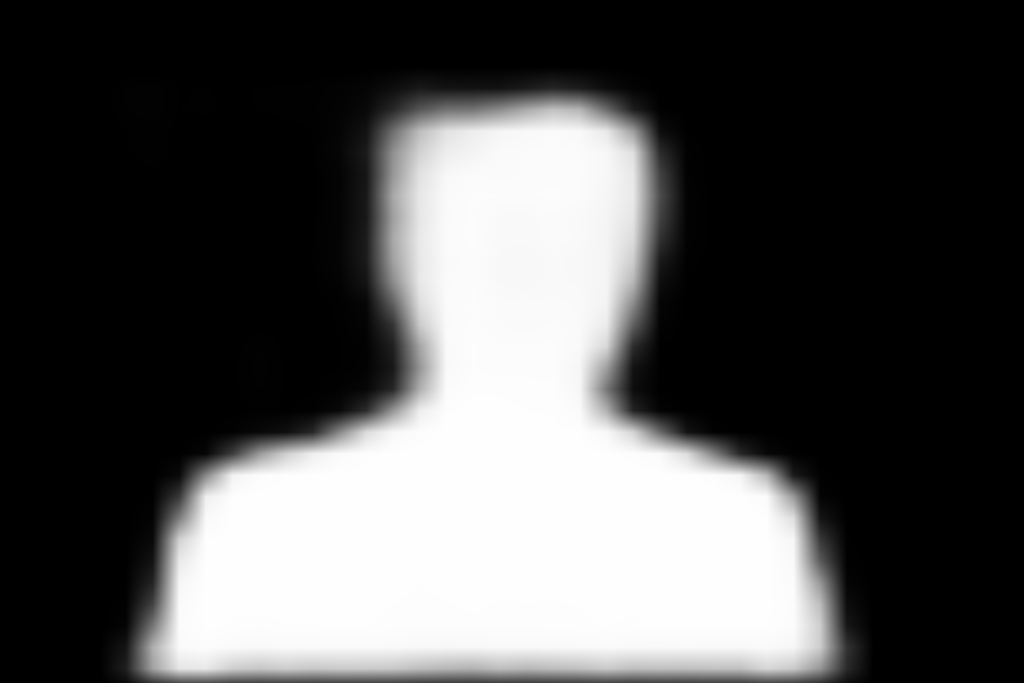

In [ ]:
y = predictions[0]['masks']
tra = torchvision.transforms.ToPILImage()
tra(y[0])


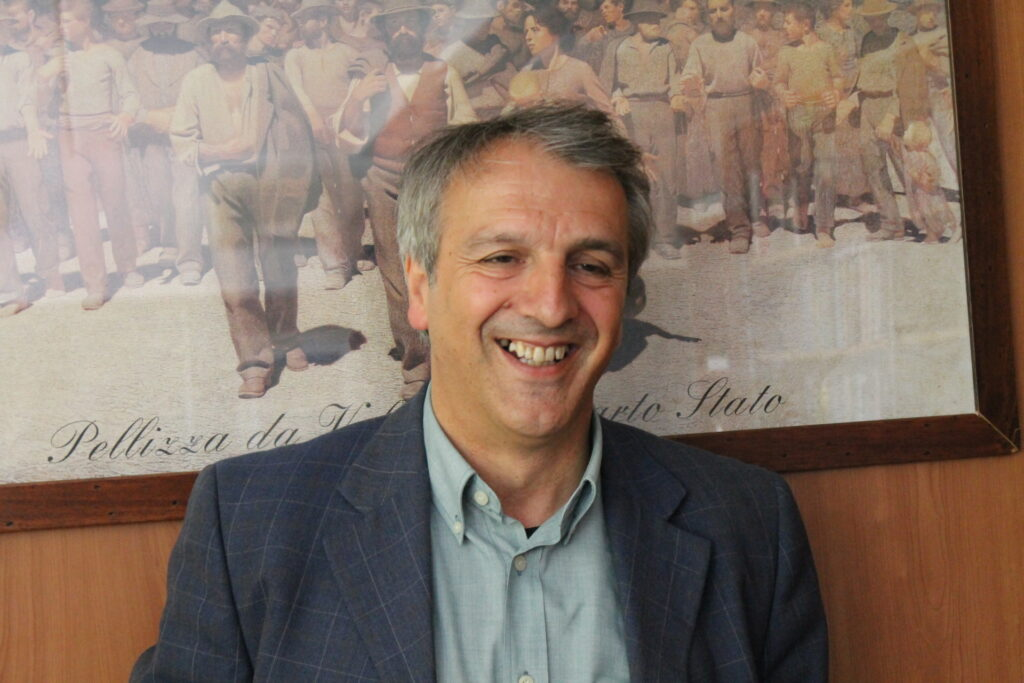

In [ ]:
x=torchvision.io.read_image('/content/sergio.jpg')/255
tra(x)

In [ ]:
predictions

[{'boxes': tensor([[1.1341e+02, 7.7807e+01, 8.5992e+02, 6.7921e+02],
          [1.6541e+02, 1.6666e+01, 3.3783e+02, 3.9813e+02],
          [5.0574e+01, 8.3681e+00, 1.4818e+02, 3.1062e+02],
          [7.6909e+02, 5.4649e+00, 8.4143e+02, 2.3190e+02],
          [6.7642e+02, 3.8989e+00, 7.7638e+02, 2.4929e+02],
          [6.0298e+02, 9.7427e+00, 6.8534e+02, 2.3312e+02],
          [5.0966e+02, 1.1271e+01, 6.1762e+02, 1.0784e+02],
          [3.4776e+02, 2.5644e+01, 4.6876e+02, 3.7252e+02],
          [1.9657e+00, 2.6731e+01, 6.8880e+01, 3.1121e+02],
          [1.2344e+02, 1.1819e+01, 2.0076e+02, 2.7165e+02],
          [4.3804e+02, 1.9766e+00, 5.3497e+02, 1.1574e+02],
          [8.0334e+02, 5.8134e+00, 8.5422e+02, 2.2995e+02],
          [2.7985e+02, 1.7523e+01, 3.7145e+02, 2.9628e+02],
          [2.0927e+02, 0.0000e+00, 4.3679e+02, 4.0628e+02],
          [8.1481e+02, 4.9986e+00, 8.6164e+02, 1.2432e+02],
          [7.4758e+02, 5.0043e+00, 7.9005e+02, 7.6082e+01],
          [6.6198e+02, 1.0931e+